Analysis 1. SFMTA fare calculation table states that the fare for a trip of x miles will be at least
3.5 + 0.55 × (5x − 1). Explore how this compares to the actual relationship between fares and distance that
you can find using regression methods that you have learned in class.


In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
taxi = Table().read_table("SF_taxi_data.csv")
taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,2.12241
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312


In [3]:
refined_data = taxi.where("num", 1).where("fare ($)", are.above(3.5))

In [4]:
refined_data #Get trips where the number of passengers is only 1, and remove fares less than $3.5, since base fare
   # = $3.5, these are likely to be errors. Do the rest of analysis on this filtered data.

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807


In [61]:
refined_data_1 = refined_data.select( 'dist (miles)',"fare ($)")

In [62]:
refined_data_1

dist (miles),fare ($)
1.98084,13.2
2.40224,10.65
0.479348,9
1.03807,7.35
0.960851,11.75
0.414315,5.15
14.5105,43.65
14.2747,46.75
0.685312,6.25
1.59807,9.55


In [63]:
def prediction(table):
    x= table.column(0) 
    predictions = 3.5 + (0.55 * (5*x - 1))
    return predictions

In [64]:
guesses = prediction(refined_data_1)

In [65]:
truth = refined_data_1.column(1) #actual responses
error_formula = truth - guesses 
error_formula

array([ 4.80270332,  1.09383684,  4.73179207, ...,  3.69851124,
        4.57879108,  2.92222165])

In [72]:
x = refined_data_1["dist (miles)"]
y = refined_data_1["fare ($)"]
theta1 = np.sum(x*(y-np.mean(y)))/np.sum(x*(x-np.mean(x)))
theta2 = -theta1*np.mean(x) + np.mean(y)
theta1, theta2

(3.3340758853754773, 5.0860057579720372)

In [73]:
def prediction_lin_r(table, slope, intercept):
    x= table.column(0) 
    predictions = slope * x + intercept
    return predictions

In [74]:
guess_lin = prediction_lin_r(refined_data_1, theta1, theta2)
guess_lin

array([ 11.69026048,  13.09526005,   6.68418949, ...,   6.90639757,
        52.21311859,  12.21217269])

In [75]:
error_lin = truth - guess_lin
error_lin

array([ 1.50973952, -2.44526005,  2.31581051, ...,  1.24360243,
       -5.81311859, -0.46217269])

In [76]:
information = refined_data_1.with_columns("Formula Predictions", guesses, "Linear Regression Predictions", guess_lin)
information

dist (miles),fare ($),Formula Predictions,Linear Regression Predictions
1.98084,13.2,8.3973,11.6903
2.40224,10.65,9.55616,13.0953
0.479348,9,4.26821,6.68419
1.03807,7.35,5.80469,8.54701
0.960851,11.75,5.59234,8.28956
0.414315,5.15,4.08937,6.46736
14.5105,43.65,42.854,53.4653
14.2747,46.75,42.2054,52.6789
0.685312,6.25,4.83461,7.37089
1.59807,9.55,7.34469,10.4141


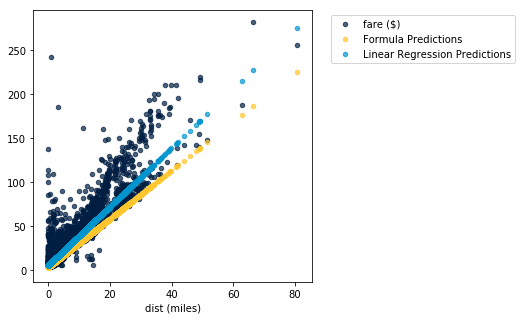

In [80]:
information.scatter(0)

In [86]:
def rmse(error):
    return np.sqrt(np.mean((error)**2))

In [87]:
rmse(error_formula)

7.1313685583381421

In [88]:
rmse(error_lin)

5.0413780143455149

### the error for regression was less, and regression was a better predictor.